
# Linear Regression
**Assumptions**

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.


**Ref:**
1. [Math Differential Calculus](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/math_differential_calculus.ipynb#scrollTo=nwzF_EXtqqe1)

2. [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975/ref=asc_df_1098125975/?tag=hyprod-20&linkCode=df0&hvadid=564681728094&hvpos=&hvnetw=g&hvrand=12536021134787862812&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9061321&hvtargid=pla-1651497364252&psc=1&mcid=ee20b34166b93f94b9a88a727e2204b3&gclid=CjwKCAjwt-OwBhBnEiwAgwzrUvy6fyRVoCj9LZC1E4kgyL5KvZKoFNJFSWa2nRThyPByYb_YQCTPERoCVQsQAvD_BwE)


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/sachinprasadhs/AI-Concepts/blob/master/Common%20Concepts/Linear%20Regression/linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Import Necessary Libraries

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm

## Generate Random Dataset

In [2]:
num_samples = 1000
num_features = 5
key = jax.random.PRNGKey(seed=42)

In [3]:
random_coeff = jax.random.randint(key, shape=[num_features], minval=-10, maxval=10)

X = 2 * jax.random.normal(key, shape=(num_samples, num_features))

# Generate Random Bias and Coefficients
random_bais = jax.random.choice(key, random_coeff, shape=(1,))
random_coeff = jax.random.choice(key, random_coeff, shape=(num_features,))

print(f"Random Bias: {random_bais}")
print(f"Random Coefficients: {random_coeff}")

coeff_features = []

# Construct each feature with random coeffcients choosen
for idx, coeff in enumerate(random_coeff):
  coeff_features.append(coeff * X[:, idx:idx+1])

# Print equation
equation = f"Y = {random_bais[0]}"
for idx, coeff in enumerate(random_coeff):
  equation += f" + {coeff} * X{idx+1}"
print(equation)


# Stack the features into a single matrix
coeff_features = jnp.hstack(coeff_features)

# Generate output from random data
y = random_bais + jnp.sum(coeff_features, axis=1) + jax.random.normal(key, shape=(num_samples,))

Random Bias: [-6]
Random Coefficients: [-3 -1 -3 -6 -6]
Y = -6 + -3 * X1 + -1 * X2 + -3 * X3 + -6 * X4 + -6 * X5


## Normal Equation

$$\theta = (X^TX)^{-1} X^Ty$$

* The Normal Equation computes the inverse of $X^T X$, which is an $(n + 1) × (n + 1)$
matrix (where n is the number of features). The computational complexity of inverting
such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ (depending on the implementation).
In other words, if you double the number of features, you multiply the computation
time by roughly 22.4 = 5.3 to 23 = 8

* $X^TX$ is always guaranteed to be symmetric and positive semi-definite (non-negative eigenvalues), but that doesn't necessarily mean it's invertible.
  * **Linear Depedence:** $X^TX$ not being invertible implies the columns (or rows, since it's symmetric) of the original matrix X are linearly dependent. This means one column can be recreated by a linear combination of other columns. Imagine X has redundant information.
  * **Non-Unique Solutions:**  In contexts like linear regression where X^TX is used to find a best-fit line, non-invertibility indicates there isn't a single unique solution for the unknown variables. There might be multiple lines that fit the data about equally well.
  * **Rank and Interpretation:** The rank of X, which is essentially the number of linearly independent columns (or rows), is less than the total number of columns (or rows) if $X^TX$ is not invertible. This can point to issues with the data or model being used.

* Even when $X^TX$ is not invertible, alternative methods like the Moore-Penrose pseudoinverse can be used to find solutions, although they might not be unique.

* Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regards to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.



In [4]:
class NormFit:
    """
    A class for fitting and predicting using the normal equation.

    Attributes:
        theta (numpy.ndarray): The parameters of the linear regression model.
    """

    def __init__(self):
        """
        Initialize the NormFit class with theta set to None.
        """
        self.theta = None

    def fit(self, X: jnp.ndarray, y: jnp.ndarray)-> jnp.ndarray:
        """
        Fit the linear regression model using the normal equation.

        Args:
            X (numpy.ndarray): The input features.
            y (numpy.ndarray): The target values.

        Returns:
            numpy.ndarray: The learned parameters (theta).
        """
        X_b = jnp.hstack((jnp.ones((X.shape[0], 1)), X))  # Add a column of ones for the bias term
        self.theta = jnp.linalg.pinv(X_b).dot(y)  # Use np.linalg.pinv instead of np.linalg.inv for better numerical stability
        return self.theta

    def predict(self, X: jnp.ndarray)-> jnp.ndarray:
        """
        Predict the target values using the learned model.

        Args:
            X (numpy.ndarray): The input features.

        Returns:
            numpy.ndarray: The predicted target values.
        """
        return X.dot(self.theta)  # Corrected: Use self.theta instead of theta

### Fit Normal Equation to Data to get Weights/Coefficients

In [5]:
normfit = NormFit()
theta = normfit.fit(X, y)

predicted_eq = f"Y_ = {jnp.round(theta[0], 1)}"
for idx, coeff in enumerate(theta[1:]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = -6.0 + -3.0 * X1 + -1.0 * X2 + -3.0 * X3 + -6.0 * X4 + -6.0 * X5


## Gradient Descent Training


* Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.
* Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope.
* This is exactly what Gradient Descent does: **it measures the local gradient of the error function with regards to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!**
* An important parameter in Gradient Descent is the size of the steps, determined by the `learning rate` hyperparameter.
  * If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
  * On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution


## Linear Regression Gradient Descent:

$$ MSE(\theta) = \dfrac{1}{m} * \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{i})^{2}$$
\
$$ \dfrac{\partial}{\partial \theta_j}MSE(\theta) = \dfrac{2}{m} * \sum_{i=1}^{m} (\theta^Tx^{(i)} - y^{(i)}) \, \, x_{j}^{(i)}$$
\
$$ \nabla_\theta MSE(\theta) = \left\{ \begin{array}{c}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{ MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{array} \right\} = \dfrac{2}{m}X^{T}(X\theta - y)$$

$$ \theta^{(next \, step)} = \theta - 𝞰\nabla_\theta MSE(\theta) $$

In [6]:
class LinearRegression:
    """
    Linear Regression model implementation using JAX.

    Attributes:
        key (jnp.ndarray): Random key for weight initialization.
        lr (float): Learning rate for gradient descent.
        epochs (int): Number of training epochs.
        W (jnp.ndarray): Weights of the linear regression model.
    """

    def __init__(self, key, lr: float = 0.01, epochs: int = 1000):
        self.key = key
        self.lr = lr
        self.epochs = epochs
        self.W: jnp.ndarray = None

    def fit(self, X: jnp.ndarray, y: jnp.ndarray) -> None:
        """
        Fit the linear regression model to the training data.

        Args:
            X (jnp.ndarray): Input features of shape (num_samples, num_features).
            y (jnp.ndarray): Target values of shape (num_samples,) or (num_samples, 1).
        """
        num_features = X.shape[1]
        self.W = jax.random.normal(self.key, shape=(num_features + 1, 1))  # (num_features + bias term, 1)
        X = jnp.hstack((jnp.ones(shape=(X.shape[0], 1)), X))  # (add column for bias term which will be one)
        y = y.reshape(-1, 1)  # Ensure y has shape (num_samples, 1)

        for epoch in range(self.epochs):
            # Forward Pass
            y_pred = X @ self.W  # (num_samples, num_features + 1) @ (num_features + 1, 1) -> (num_samples, 1)

            # Calculate Gradient
            dW = (2 / X.shape[0]) * (X.T @ (y_pred - y))  # (num_features + 1, num_samples) @ (num_samples, 1) -> (num_features + 1, 1)

            # Update Weights
            self.W -= self.lr * dW

            if (epoch + 1) % 100 == 0:
                loss = (1/X.shape[0]) * jnp.sum((y_pred - y) ** 2)
                print(f"Epoch {epoch + 1}: Loss {loss}")

    def predict(self, X: jnp.ndarray) -> jnp.ndarray:
        """
        Predict the target values for the given input features.

        Args:
            X (jnp.ndarray): Input features of shape (num_samples, num_features).

        Returns:
            jnp.ndarray: Predicted target values of shape (num_samples, 1).
        """
        X = jnp.hstack((jnp.ones(shape=(X.shape[0], 1)), X))  # Add bias term
        return X @ self.W

### Fit the Dataset using Linear Regression

In [7]:
lr = LinearRegression(key, lr=0.01, epochs=1000)

In [8]:
lr.fit(X, y)

Epoch 100: Loss 1.8895609378814697
Epoch 200: Loss 1.0532819032669067
Epoch 300: Loss 1.0381032228469849
Epoch 400: Loss 1.037827730178833
Epoch 500: Loss 1.0378227233886719
Epoch 600: Loss 1.0378226041793823
Epoch 700: Loss 1.0378226041793823
Epoch 800: Loss 1.0378226041793823
Epoch 900: Loss 1.0378226041793823
Epoch 1000: Loss 1.0378226041793823


### Check the coefficients

In [9]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)}"
for idx, coeff in enumerate(lr.W[1:, 0]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = -6.0 + -3.0 * X1 + -1.0 * X2 + -3.0 * X3 + -6.0 * X4 + -6.0 * X5


## Convex Functions

* In mathematics, a real-valued function is called convex if the line segment between any two distinct points on the graph of the function lies above the graph between the two points.

* Let $X$ be convex subset of real vector space and let $f: X → ℝ$

* Then $f$ is called convex if and only if any of the following equivalent conditions hold:
  * For all $0 \leq t \leq 1$ and $x_1, x_2 \, 𝜖 \, X$
  $$ f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2)$$

* Properties of Convex funtcion:
  * Any local minima is global minima.
  * Where it exists, the hessian(second partial derivate) is positive semi-definite.
  * Sum of two convex function is a convex function.
  * max of two convex functions is a convex function.
  

## California House Price Prediction

In [10]:
df = pd.read_csv("./sample_data/california_housing_train.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


### Check for null values

In [11]:
df.isna().sum(axis=0)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

## Let's plot latitude and longitude with house median values

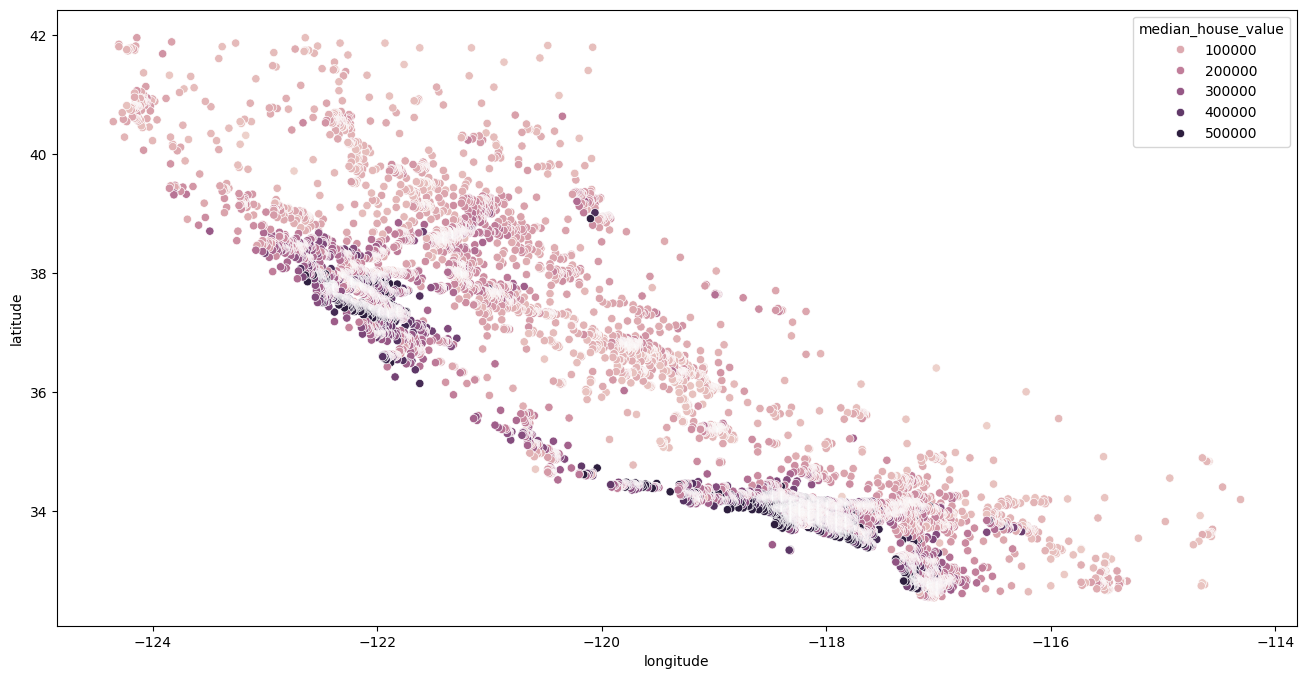

In [12]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['median_house_value'])
plt.show()

### Let's look at the correlation matrix

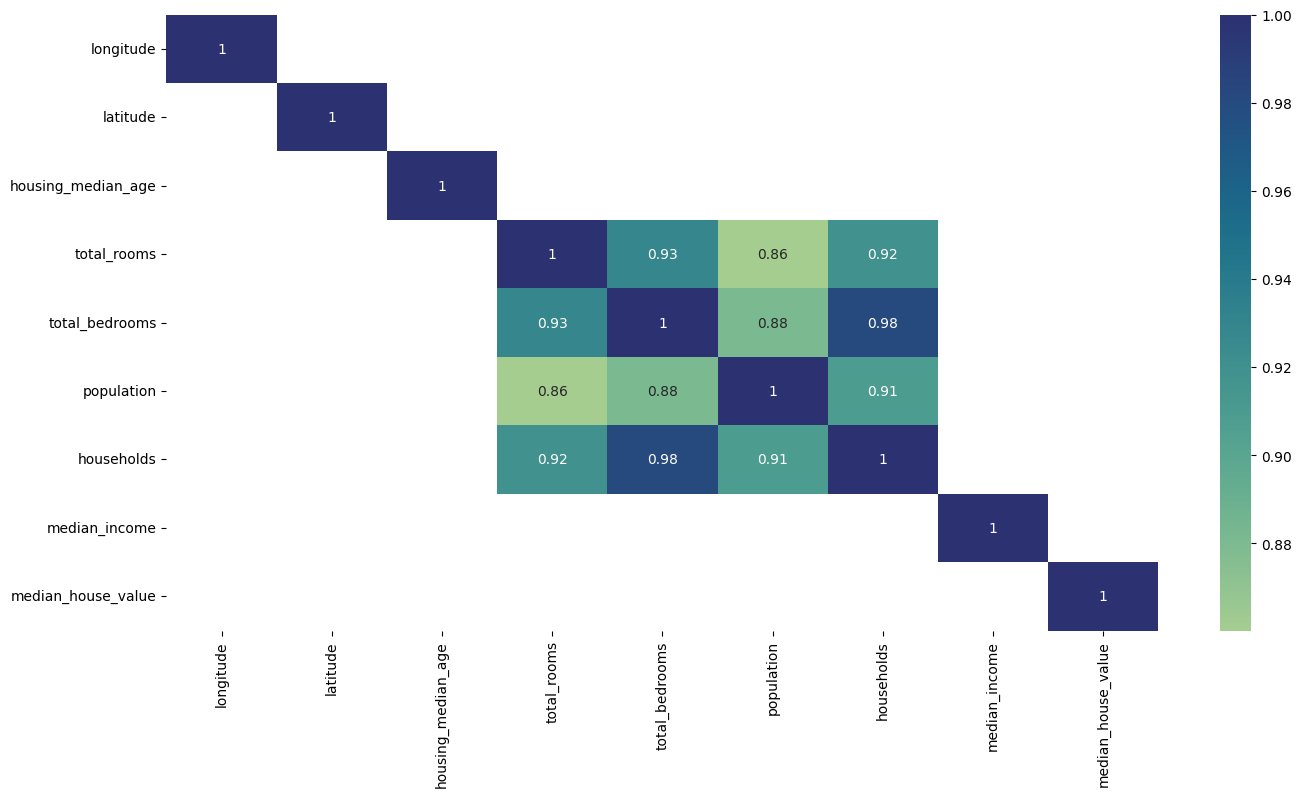

In [13]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr()[df.corr() >= 0.7], annot=True, cmap="crest")
plt.show()

### Get feature and target columns

In [14]:
feature_columns = list(df.drop('median_house_value', axis=1).columns)
target_column = ["median_house_value"]

### Let's split the data to train and validation

In [82]:
train_df, val_df, train_y, val_y = train_test_split(
    df.drop('median_house_value', axis=1),
    df['median_house_value'],
    random_state=42)

### Pipelines for features and target separately

In [15]:
features_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

target_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

### Standardize the data

* Here to observe is that never fit_transform with validation data which will be lekage of the data.

In [86]:
X_train = features_scaling_pipe.fit_transform(train_df)
y_train = target_scaling_pipe.fit_transform(train_y.values.reshape(-1, 1))

### Train the model using Linear Regression

In [87]:
lr = LinearRegression(key, lr=0.01, epochs=1000)

lr.fit(X_train, y_train)

Epoch 100: Loss 0.5196395516395569
Epoch 200: Loss 0.4637480676174164
Epoch 300: Loss 0.43818262219429016
Epoch 400: Loss 0.41999709606170654
Epoch 500: Loss 0.40664592385292053
Epoch 600: Loss 0.396765798330307
Epoch 700: Loss 0.3894062340259552
Epoch 800: Loss 0.3838891088962555
Epoch 900: Loss 0.3797267973423004
Epoch 1000: Loss 0.3765661418437958


### Let's validate the model

In [90]:
X_val = features_scaling_pipe.transform(val_df)
y_val = target_scaling_pipe.transform(val_y.values.reshape(-1, 1))

In [91]:
y_val = target_scaling_pipe.inverse_transform(y_val.reshape(-1, 1))
y_pred = target_scaling_pipe.inverse_transform(lr.predict(X_val))

### Check RMSE
* $$ MSE = \dfrac{1}{m} \sum_{i=1}^{m} (y^{i}_{pred} - y_{i})^{2} $$
* As MSE will be very high due to high values of the house prices

In [94]:
print(f"Root Mean Squared Error:{skm.mean_squared_error(y_val, y_pred, squared=False)}")

Root Mean Squared Error:69919.26264841524


### Let's plot upto 50 predictions using seaborn

In [92]:
idxs = val_df.reset_index(drop=True).index

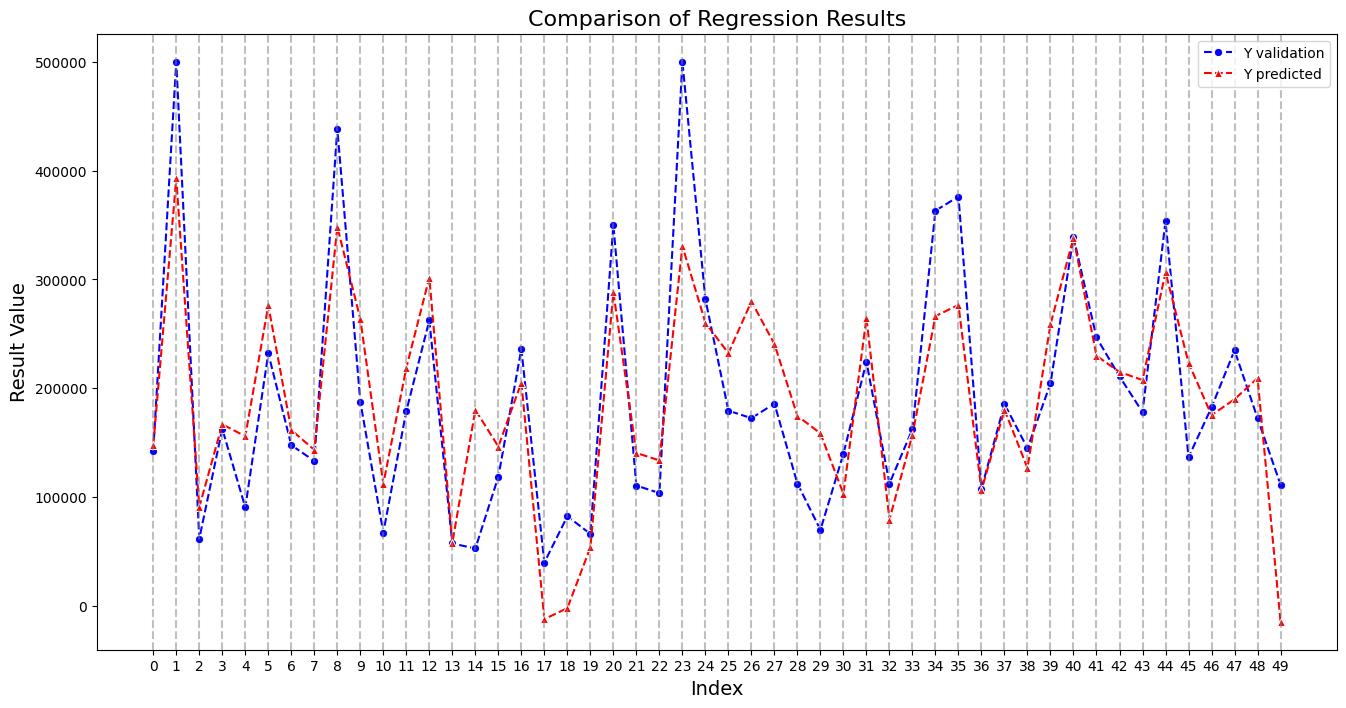

In [81]:
points = 50

plt.figure(figsize=(16, 8))
ax = sns.lineplot(x=idxs[:points],
                  y=y_val.reshape(-1)[:points],
                  color='b',
                  marker='o',
                  label='Y validation',
                  linestyle='--')
sns.lineplot(x=idxs[:points],
             y=y_pred.reshape(-1)[:points],
             color='r',
             marker='^',
             label='Y predicted',
             linestyle='--')


# Add vertical and horizontal lines
for idx in idxs[:points]:
  ax.axvline(idx, color='gray', linestyle='--', alpha=0.5)


# Add gridlines at each index
ax.set_xticks(idxs[:points])

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Result Value', fontsize=14)
plt.title('Comparison of Regression Results', fontsize=16)

# Add legend
plt.legend()

plt.show()